# Timeseries Analysis
Below done with test data, same format as df_data

In [6]:
import os, inspect, sys
import numpy as np
import pandas as pd
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
main_dir = '/'.join(curr_dir.split('/')[:-1])
python_dir = os.path.join(main_dir, 'RGCPD')
df_ana_dir = os.path.join(main_dir, 'df_analysis/df_analysis/')
if main_dir not in sys.path:
    sys.path.append(main_dir)
    sys.path.append(python_dir)
    sys.path.append(df_ana_dir)

In [8]:
import functions_pp
import df_ana
from class_RV import RV_class
%load_ext autoreload
%autoreload 2
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

4 cpu's detected


/Users/semvijverberg/miniconda3/envs/df_ana/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


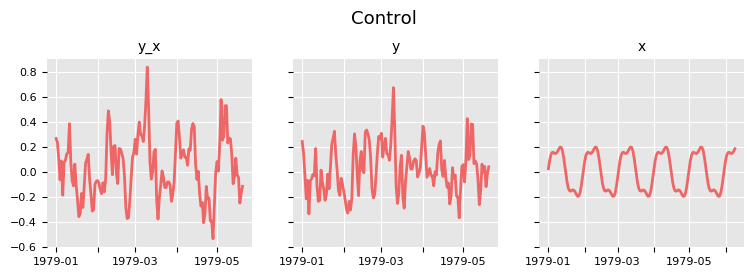

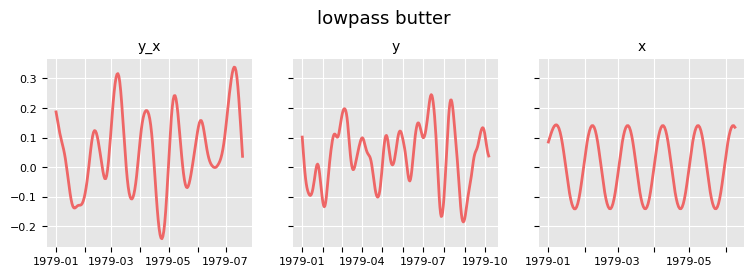

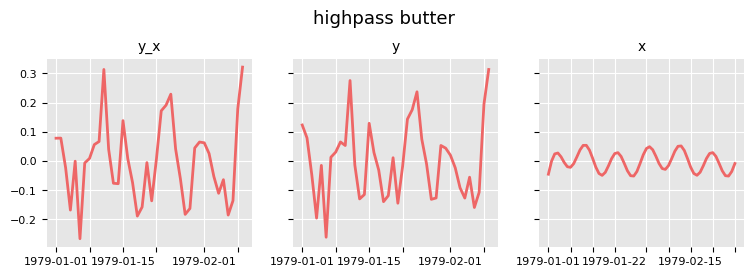

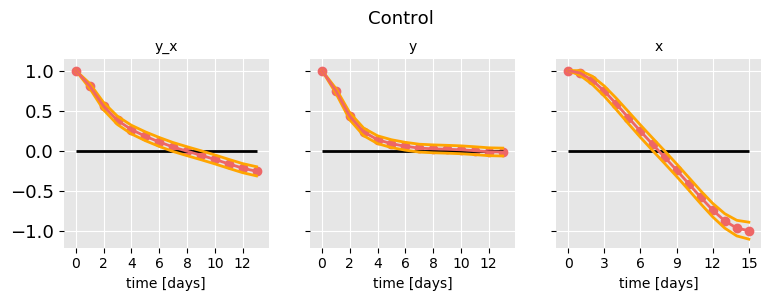

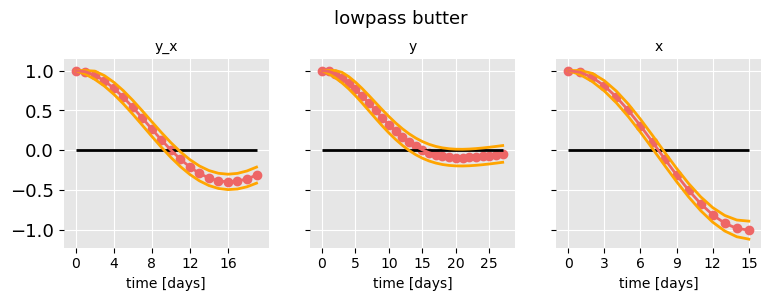

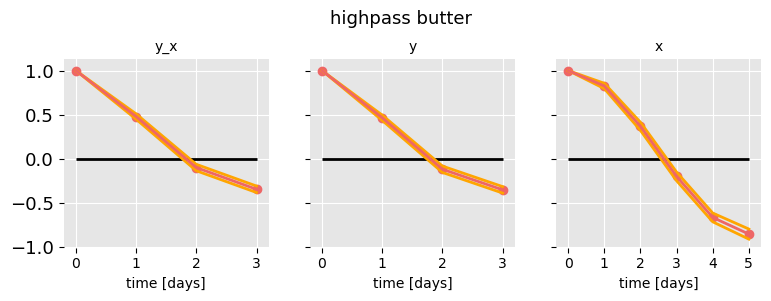

In [9]:
import df_ana
import filters
from statsmodels.tsa.arima_process import ArmaProcess
import xarray as xr

np.random.seed(1)

N_cycles = 20
cycle = 365
ARc = np.array([.75, -.12])
MAc = np.array([.25, -0.02])
LFV1_period = 30/cycle
LFV2_period = 10/cycle
cut_off_lowpass = 12
cut_off_highpass = 8
LFV1_a = 0.2
LFV2_a = 0.05
additive=True

def get_artifical_ts(N_cycles, cycle, ARc, MAc, LFV1_period, LFV2_period, LFV1_a=0.1, LFV2_a=0.05):
    y_ = ArmaProcess.from_coeffs(ARc, MAc).generate_sample(scale=.15, nsample=cycle*N_cycles)# np.random.rand((12*N))
    x_ = np.array([LFV1_a*np.sin(2*np.pi/LFV1_period*t) + LFV2_a*np.sin(2*np.pi/LFV2_period*t+.5) for t in np.arange(cycle*N_cycles)/cycle])
    y_ -= np.mean(y_)
    y_x = x_ + y_

    data = np.stack([y_x, y_, x_], axis=1)
    index = pd.date_range(start='1979-01-01', end=f'{1979+N_cycles-1}-12-31')
    index = df_ana.remove_leapdays(index)
    df_new = pd.DataFrame(data, index=index, columns=['y_x', 'y', 'x'])
#     df_new = pd.concat([df_new], keys=[0])
    return df_new

df_art = get_artifical_ts(N_cycles, cycle, ARc, MAc, LFV1_period, LFV2_period, LFV1_a=LFV1_a, LFV2_a=LFV2_a)

man1 = ('lowpass butter', filters.lowpass, {'period':cut_off_lowpass})
man2 = ('highpass butter', filters.highpass, {'period':cut_off_highpass})
manipulations = ['Control', man1, man2]
def plot_manip_stat(df_data, manipulations, plot_function):
    for c, manip in enumerate(manipulations):
        if manip == 'Control':
            df_man = df_data.copy()
            title  = manip
        elif manip != 'Control':
            df_man = df_data.copy()
            title  = manip[0]
            function_ = manip[1]
            kwrgs_ = manip[2]
            df_man = df_ana.loop_df_ana(df_man, function_, kwrgs=kwrgs_)  

        

        func_, kwrgs_ = plot_function
        fig = df_ana.loop_df(df_man, func_, kwrgs=kwrgs_, sharex='none')
        fig.text(0.5, 1.02, title, horizontalalignment='center')
        
plot_manip_stat(df_art, manipulations, (df_ana.plot_timeseries, {}) )

# plot_manip_stat(df_art, manipulations, (df_ana.plot_spectrum, {}) )

plot_manip_stat(df_art, manipulations, (df_ana.plot_ac, {}) )



In [131]:

def df_data_to_RGCPD_format(fullts, RV_ts, df_data, kwrgs_TV):
    RV = RV_class(fullts, RV_ts)
    
    df_splits = functions_pp.rand_traintest_years(RV, verb=0, **kwrgs_TV)                                    
    # add Train test info
    splits = df_splits.index.levels[0]
    df_data_s   = np.zeros( (splits.size) , dtype=object)
    for s in splits:
        df_data_s[s] = pd.merge(df_data, df_splits.loc[s], left_index=True, right_index=True)
    df_data  = pd.concat(list(df_data_s), keys= range(splits.size))
    return df_data

kwrgs_TV = dict(method='random10',
                        seed=1,
                        kwrgs_events=None)

df_art = get_artifical_ts(N_cycles, cycle, ARc, MAc, LFV1_period, LFV2_period, LFV1_a=LFV1_a, LFV2_a=LFV2_a)

df_data = df_data_to_RGCPD_format(df_art.iloc[:,0], df_art.iloc[:,0], df_art, kwrgs_TV)

dict_of_dfs = {'df_data':df_data}
filepath = os.path.join(os.getcwd(), 'df_data.h5')
df_ana.store_hdf_df(dict_of_dfs, filepath)

filepath

'/Users/semvijverberg/surfdrive/Scripts/RGCPD/RGCPD/df_analysis/df_data.h5'

In [114]:
from statsmodels.tsa.arima_model import ARMA

def load_hdf5(path_data):
    hdf = h5py.File(path_data,'r+')
    dict_of_dfs = {}
    for k in hdf.keys():
        dict_of_dfs[k] = pd.read_hdf(path_data, k)
    hdf.close()
    return dict_of_dfs
    
strat_1d_CPPA_era5 = '/Users/semvijverberg/surfdrive/MckinRepl/era5_T2mmax_sst_Northern/ran_strat10_s30/data/era5_24-09-19_07hr_lag_0.h5'
CPPA_sm_10d   = '/Users/semvijverberg/surfdrive/RGCPD_mcKinnon/t2mmax_E-US_sm123_m01-09_dt10/18jun-17aug_lag0-0_ran_strat10_s30/pcA_none_ac0.05_at0.05_subinfo/fulldata_pcA_none_ac0.05_at0.05_2019-09-24.h5'
df_data = load_hdf5(strat_1d_CPPA_era5)['df_data']
keys = ['t2mmax', '0_2_sst', '0_901_PDO']
df_data = df_data.loc[0].loc[:,keys]

df_RV = df_data.iloc[:,[0]]

df_RV = df_ana.loop_df_ana(df_RV, filters.highpass, kwrgs={'period':100})  

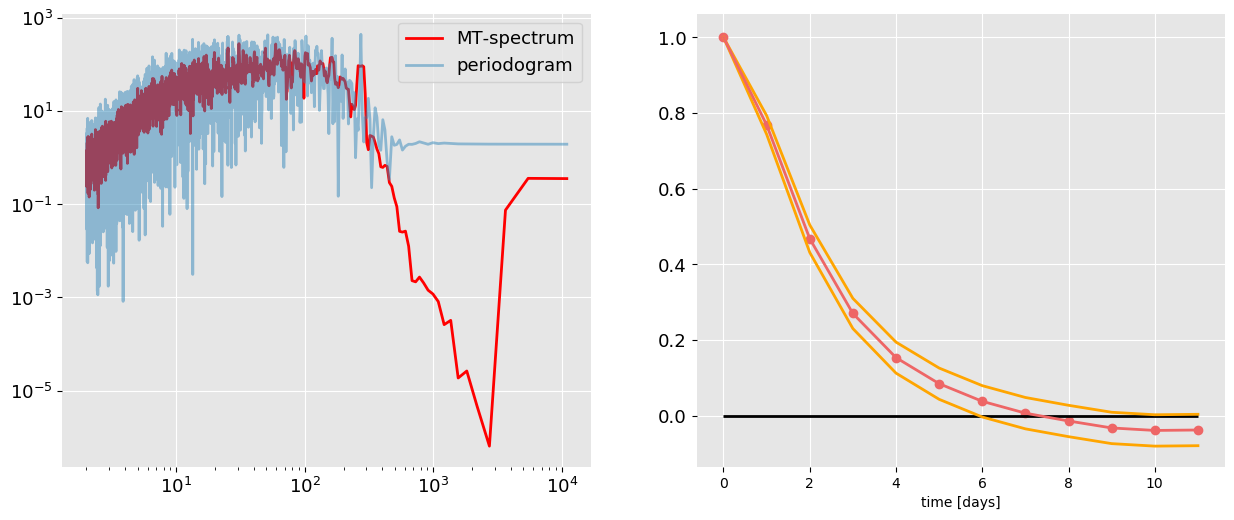

In [121]:
import matplotlib.pyplot as plt 
import numpy as np
import scipy as sp

y = df_RV.iloc[:,0]
freq_df = (df_RV.index[1] - df_RV.index[0]).days

fig, ax = plt.subplots(1,2, figsize=(15,6))


freq, Pxx = df_ana.mtspectrum(y)
ax[0].plot(1*freq_df/(freq[1:]), Pxx[1:], label='MT-spectrum', color='red')
ax[0].loglog()
freq, spec = df_ana.periodogram(y)
ax[0].plot(1*freq_df/(freq[1:]), spec[1:], ls='-', c='C1', alpha=0.5, label='periodogram')  
ax[0].legend()

df_ana.plot_ac(df_RV, ax=ax[1])
# ax[1].set_xlim(0,60)





In [123]:
result = ARMA(df_RV, order=(2,2)).fit()
result.params

/Users/semvijverberg/miniconda3/envs/df_ana/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


const          -0.008713
ar.L1.t2mmax    0.781385
ar.L2.t2mmax   -0.124536
ma.L1.t2mmax    0.246494
ma.L2.t2mmax   -0.021950
dtype: float64

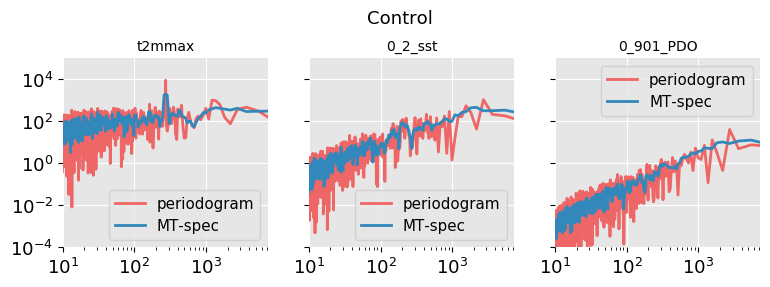

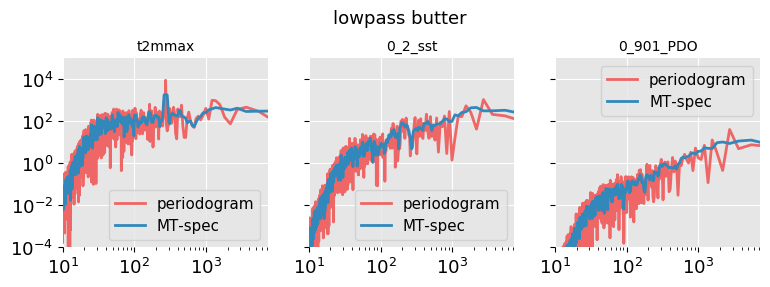

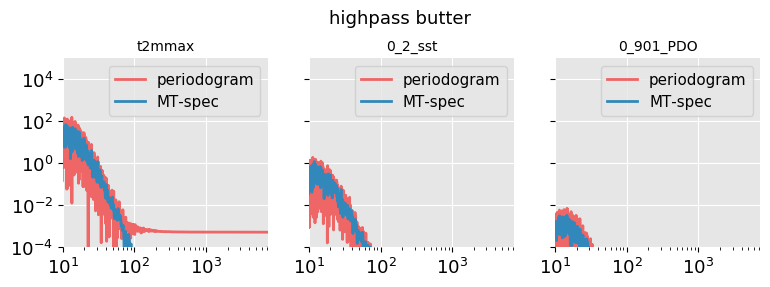

In [105]:
plot_manip_stat(df_data, manipulations, (df_ana.plot_spectrum, {'x_lim':(10,20*365), 'y_lim':(1E-4, 1E5)}) )

,t2mmax_E-US,0_2_sst,0_901_PDO
1979-01-09,1.207499,-0.235460,-0.034240
1979-01-19,4.776447,0.367136,-0.072244
1979-01-29,2.846140,0.407948,-0.050702
1979-02-08,-0.656079,0.410842,-0.124501
1979-02-18,2.786209,1.095554,-0.169418
...,...,...,...
2018-08-17,2.899132,-1.026979,0.079285
2018-08-27,3.706010,-1.224292,0.078419
2018-09-06,4.424036,-0.870125,0.079122
2018-09-16,6.088548,-0.378774,0.095454


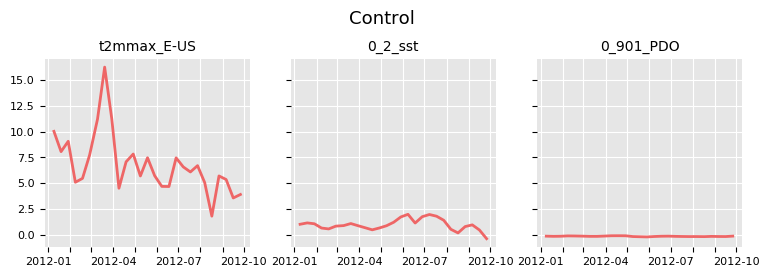

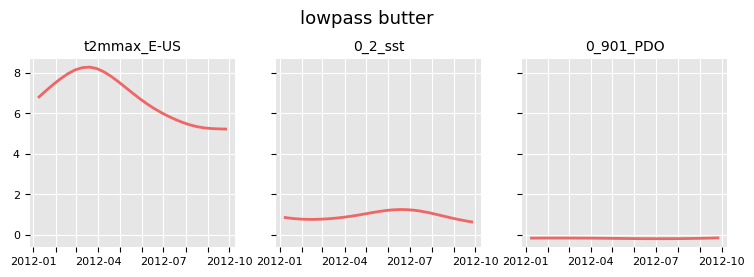

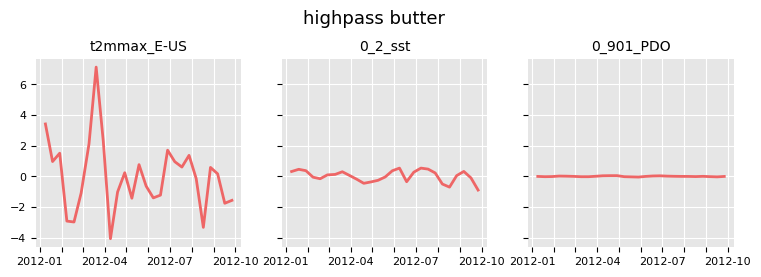

In [519]:
plot_manip_stat(df_data, manipulations, (df_ana.plot_timeseries, {'selyears':[2012]}) )

In [ ]:
df_art = get_artifical_ts(N_cycles, cycle, ARc, MAc, LFV1_period, LFV2_period, LFV1_a=0.1, LFV2_a=0.05)

# def bandpass_y_x(y, x)

man1 = ('lowpass butter', filters.lowpass, {'period':cut_off_lowpass})
man2 = ('highpass butter', filters.highpass, {'period':cut_off_highpass})

df_art.columns.size+1
manipulations = ['Control', man1, man2]
f, ax = plt.subplots(df_art.columns.size+2,len(manipulations), figsize=(15,10))
i=0
for c, manip in enumerate(manipulations):
    
    if manip == 'Control':
        df_man = df_art.copy()
        title  = manip
    elif manip != 'Control':
        df_man = df_art.copy()
        title  = manip[0]
        function_ = manip[1]
        kwrgs_ = manip[2]
        df_man = df_ana.loop_df_ana(df_man, function_, kwrgs=kwrgs_)

    yx = df_man.loc[:,'y_x']
    y  = df_man.loc[:,'y']
    x = df_man.loc[:,'x']
    corrcoeff = np.corrcoef(yx, x)[1][0]
    ax[0,c].set_title(title)
#     ax[0,c].set_xlim(0,cycle)
    ax[0,c].plot(y.index, yx, alpha=.7)
    ax[0,c].plot(y.index, y, alpha=.7)
    ax[0,c].text(0,0.95,f"Corr. Coeff={round(corrcoeff,2)}",transform=ax[0,c].transAxes)
    ax[0,c].plot(x.index, x, alpha=.7)
    
    for r, header in enumerate(df_man):
        da = df_man[header]
        # two plots for y and x
        ax[r+1,c].axvline(LFV1_period*cycle, c='k')
        ax[r+1,c].axvline(LFV2_period*cycle, c='k')
        freq, spec = df_ana.periodogram(da)
        ax[r+1,c].plot(1/(freq[1:]), spec[1:], ls='-', c='C1', label='periodogram')  
        
        freq, spec = df_ana.mtspectrum(da)
        ax[r+1,c].plot(1/(freq[1:]), spec[1:], ls='--', c='C0', label='MT-spec')
                    
        ax[r+1,c].loglog()
        ax[r+1,c].set_ylim(1e-4,1e2)   
        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=int(-1E-99+cycle/100) + 1) 
        ax[r+1,c].xaxis.set_major_locator(locmaj)
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=tuple(np.arange(0,1,0.1)[1:]),numticks=int(-1E-99+cycle/100) + 1)
        ax[r+1,c].xaxis.set_minor_locator(locmin)
        ax[r+1,c].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax[r+1,c].set_xlim(1, cycle)
        
    df_ana.plot_ac(df_man.loc[:,'y_x'], ax=ax[-1,c])
        

    ax[-1,c].set_xlabel('period [timesteps]')
    ax[1,c].legend()
